[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RikVoorhaar/optimization-II-2021/blob/master/notebooks/week5.ipynb)

# Week 5

This is the second Python programming homework for this course. You can do this homework either on Google colab, or on your own machine (after installing conda). Some general instructions for the exercises:

- In the description of every exercise we mention which functions you should use, and there will be a link to the relevant documentation. You are strongly encouraged to read the documentation, especially if you are not sure what the function does. 

- Each exersice consists of finishing some partially written code. The code you wrote is then automatically tested using a few `assert` statements. This is for your convenience, and you are requested __not to alter the tests__. If your code conforms to the instructions, and none of the tests throw an error, your answer is very likely to be correct. 

- It is possible to solve each exercise in no more than 10 lines of code, and most only need 2-3 lines. If your solution is much longer, you should try to make it shorter. In particular, don't forget that using vectorized `numpy` and `scipy` functions tends to produce shorter and much faster code than using nested Python `for` loops. 

- Before handing in, be sure to restart the IPython kernel (in colab: Runtime $\to$ Run all) and run the entire notebook top-to-bottom and check that none of the cells throw an error. 

Now we begin by running the cell below. Google colab by default uses an outdated version of CVXPY, and so we will need to update it. Additionally, we need to install `yfinance` to access stock market data for exercise 4. This may take about a minute, but this is only performed once per session. If you're running this notebook on a local python installation, make sure that this cell does not throw any errors. If it does, you will need to install additional packages. You can do this by using `pip` from the command line.

In [1]:
from importlib_metadata import version

if version('cvxpy')<'1.1.0':
    !pip install --upgrade cvxpy

try:
    import yfinance as yf
except ModuleNotFoundError:
    !pip install yfinance
    import yfinance as yf
import cvxpy as cp
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (9, 6)
import numpy as np
import pandas as pd
import scipy

## Exercise 1

Consider $A\in\mathbb{R}^{m\times n}$. Define the following _infinity norm_ of $A$:
$$
\left\|A\right\|_{\infty}:=\max_{i=1,\ldots,m}\sum_{j=1}^n\left|A_{ij}\right|\,.
$$
Observe that $\left\|A\right\|_{\infty}$ is the $\ell_\infty$-norm of the vector that consists of the $\ell_1$-norm of the columns of $A$.

Assume that $A\in\mathbb{R}^{m\times n}$ is fixed. Assume also that $k$ matrices $B^{(1)}, B^{(2)},\ldots,B^{(k)}\in\mathbb{R}^{m\times n}$ are given. We want to approximate as best as possible (in this infinity norm) the matrix $A$ using a linear combination of the matrices $B^{(i)}$. In other words, we want to find the scalars $x^{(1)},x^{(2)},\ldots, x^{(k)}$ solving the minimization problem  
$$
\begin{array}{ll}
\mbox{minimize} & \left\|A-x^{(1)}B^{(1)}-x^{(2)}B^{(2)}-\ldots-x^{(k)}B^{(k)}\right\|_{\infty}\\
	& x^{(1)}, x^{(2)},\ldots, x^{(k)}\in\mathbb{R}\,.
\end{array}
$$

### Exercise 1a)

> - Prove that the minimization problem above is equivalent to the following linear program. Type your solution in a Markdown cell below.

$$
\begin{array}{ll}	
	\mbox{minimize} &t\\
	\mbox{subject to} & -S\leq A-x^{(1)}B^{(1)}-\ldots-x^{(k)}B^{(k)}\leq S\\
		& S\mathbf 1\leq t\mathbf 1\,,\quad i=1,\ldots, n
	\end{array}
$$

where $S$ is an $m\times n$ matrix and $\mathbf 1 = (1,\dots,1)^T$.

___  

_Type your solution of the problem in this markdown cell (double click to edit it)._ You can use $\LaTeX$ by encapsulating expressions in dollar signs, e.g.: `$e^x=\sum_{n=0}^\infty \frac{x}{n!}$` gives $e=\sum_{n=0}^\infty \frac{1}{n!}$. Using two dollar signs displays the math on a seperate line. E.g. `$$ e^x=\sum_{n=0}^\infty \frac{x}{n!} $$`:
$$
    e^x=\sum_{n=0}^\infty \frac{x}{n!}
$$

___  

BEGIN SOLUTION

Note first of all that the problem is equivalent to
$$
\begin{array}{ll}	
	\mbox{minimize} &t\\
	\mbox{subject to} & \max_{i} \sum_j |A_{ij}-x^{(1)}B^{(1)}_{ij}-x^{(2)}B^{(2)}_{ij}-\ldots-x^{(k)}B^{(k)}_{ij}| \leq t\\
	\end{array}
$$

Then the constraint can be further relaxed by adding an additional variable $S$, with
$$
t\geq \sum_{j=1}^nS_{ij}\,,\quad \forall i=1,2,\ldots,m\,.
$$

Then this gives the minimization problem
$$
\begin{array}{ll}	
	\mbox{minimize} &t\\
	\mbox{subject to} & |A_{ij}-x^{(1)}B^{(1)}_{ij}-x^{(2)}B^{(2)}_{ij}-\ldots-x^{(k)}B^{(k)}_{ij}|\leq S_{ij}\quad \forall i,j\\
    & t\geq \sum_{j=1}^nS_{ij} \quad \forall i
	\end{array}
$$

We see that $t\geq \sum_jS_{ij}$ is equivalent to $t\mathbf 1\geq S\mathbf 1$. Using the fact that $|a|\leq b$ is equivalent to $-b\leq a\leq b$, then results in the required problem.

END SOLUTION

### Exercise 1b)


> Complete the code for the function `approximate_matrix` below that solves the LP version of problem (1) using CVXPY.  

___  

_Hint:_ the expression $A-x^{(1)}B^{(1)}-x^{(2)}B^{(2)}-\ldots-x^{(k)}B^{(k)}$ can easily be obtained using a for loop over `range(k)`.

In [4]:
def generate_matrices(m, n, k):
    """Generate a random Gaussian (m,n) matrix A and a list of k (m,n) matrices B"""
    np.random.seed(179)
    A = np.random.normal(size=(m, n))
    B = np.random.normal(size=(k, m, n))
    return A, B


def approximate_matrix(A, B):
    m, n = A.shape
    k = len(B)
    t = cp.Variable()
    S = cp.Variable((m, n))
    x = cp.Variable(k)

    # BEGIN SOLUTION

    residual = A
    for i in range(k):
        residual -= x[i] * B[i]
    one = np.ones(n)
    #constraints = [t >= cp.sum(S, axis=1), -S <= residual, residual <= S]
    constraints = [t >= S@one, -S <= residual, residual <= S]

    problem = cp.Problem(cp.Minimize(t), constraints)
    problem.solve()

    # END SOLUTION

    return x.value


A, B = generate_matrices(10, 10, 5)

approximate_matrix(A, B)

array([ 0.05630201,  0.14055521, -0.04789529, -0.11040376,  0.04549557])

In [ ]:
def exercise1_tests():
    A, _ = generate_matrices(10, 20, 1)
    x = approximate_matrix(A, [A])[0]
    assert (
        np.abs(x - 1) < 1e-8
    ), f"If B = [A], then optimal solution is x = [1], which has zero error. Instead we got x={x}"

    A, B = generate_matrices(5, 5, 30)
    x = approximate_matrix(A, B)
    error = np.linalg.norm(A - np.einsum("i,ijk->jk", x, B))
    assert (
        np.abs(error) < 1e-8
    ), f"""If k>m*n then we can write A as a linear combination of matrices B, and we expect very
    small error, instead we got an error of {error}"""

    A, B = generate_matrices(10, 10, 5)
    x = approximate_matrix(A, B)
    error = np.linalg.norm(A - np.einsum("i,ijk->jk", x, B))
    assert (
        np.abs(error - 10.11507336) < 1e-4
    ), f"""For m=n=10, k=5 we expected an error of about 10.115, but we got {error}"""
    assert (
        np.abs(np.sum(x) - 0.08405374) < 1e-4
    ), f"""For m=n=10, k=5 we expected the sum of x to be about 0.0840, but we got {np.sum(x)}"""


exercise1_tests()

## Exercise 2

### Exercise 2a)

> Complete the code for the function `approx_ker(A,b)` that solves the following problem using CVXPY:

$$
\begin{array}{ll}
\text{minimize} & \|x-b\|_2\\
\text{subject to} & x\in \operatorname{ker}(A)
\end{array}
$$  

___  

In [ ]:
def approx_ker(A, b):
    n, m = A.shape
    x = cp.Variable(m)

    # BEGIN SOLUTION

    objective = cp.Minimize(cp.norm(x - b))
    constraints = [A @ x == 0]
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # END SOLUTION

    return x.value


A = np.random.normal(size=(5, 10))
b = np.random.normal(size=10)
approx_ker(A, b)

array([ 0.16147945,  0.05509066, -0.03413101, -0.03432299, -0.23935239,
       -1.07462564, -1.12959667,  0.62264873, -0.31671902,  0.32842675])

In [ ]:
def exercise2a_test():
    A = np.random.normal(size=(5, 10))
    U, S, V = np.linalg.svd(A)
    b = V[-1]
    x = approx_ker(A, b)
    error = np.linalg.norm(A @ x)
    assert error < 1e-8, f"""x is not in the kernel of A"""
    error = np.linalg.norm(b - x)
    assert (
        error < 1e-8
    ), f"""If b is in the kernel of A we expect b=x, but instead b-x had norm {error}"""

    A = np.random.normal(size=(5, 5))
    b = np.random.normal(size=5)
    x = approx_ker(A, b)
    error = np.linalg.norm(x)
    assert (
        error < 1e-8
    ), f"""If A has full rank then ker A = {{0}}, so x=0 is the only feasible point. 
    Instead x had norm {error}"""

    np.random.seed(179)
    A = np.random.normal(size=(6, 10))
    b = np.random.normal(size=10)
    x = approx_ker(A, b)
    error = np.linalg.norm(A @ x)
    assert error < 1e-8, f"""x is not in the kernel of A"""
    assert (
        np.abs(np.sum(x) + 0.2034392) < 1e-4
    ), f"""For this particular problem we expect x to have sum of about -0.2034392,
    but instead we got {np.sum(x)}"""


exercise2a_test()


### Exercise 2b)

> Complete the code for the function `approx_range(A,b)` that solves the following problem using CVXPY:

$$
\begin{array}{ll}
\text{minimize} & \|x-b\|_2\\
\text{subject to} & x\in \operatorname{range}(A^T)
\end{array}
$$  

_Hint: Introduce an auxillary variable_ $y$ _to enforce the constraint and convert the problem to a quadratic program_  

____

In [ ]:
def approx_range(A, b):
    n, m = A.shape
    x = cp.Variable(m)

    # BEGIN SOLUTION

    y = cp.Variable(n)
    objective = cp.Minimize(cp.norm(x - b))
    constraints = [A.T @ y == x]
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # END SOLUTION

    return x.value


A = np.random.normal(size=(5, 10))
b = np.random.normal(size=10)
approx_range(A, b)

array([ 0.63830346,  0.01429447, -0.31453574,  0.02350188,  0.3601437 ,
       -0.02786351,  0.61436183, -0.90955392,  0.12100159,  0.2211234 ])

In [ ]:
def exercise2b_test():
    A = np.random.normal(size=(3, 8))
    b = A.T @ np.random.normal(size=3)
    x = approx_range(A, b)
    error = np.linalg.norm(b - x)
    assert (
        error < 1e-8
    ), f"""If b is the range of A.T then x=b is a solution, instead the norm of x-b is {error}"""

    np.random.seed(179)
    A = np.random.normal(size=(5, 10))
    b = np.random.normal(size=10)
    x = approx_range(A, b)

    error = np.linalg.norm(np.linalg.lstsq(A.T, x, rcond=None)[1])
    assert error < 1e-8, f"""x is not the in range of A.T"""
    error = np.linalg.norm(b - x)
    assert (
        np.abs(error - 3.383908) < 1e-4
    ), f"""Expected error for this problem is about 3.383908, but we got {error}"""


exercise2b_test()

## Exercise 3

Consider two closed convex sets $S_1,S_2\subset\mathbb{R}^n$. Consider the problem $(\star)$:
$$
\begin{array}{ll}
\text{Minimize} & \|x_1-x_2\|_2\\
\text{Subject to} & x_1\in S_1,\quad x_2\in S_2
\end{array}
$$

we will solve this problem for different convex sets. 

### Exercise 3a)


>Take as convex sets two lines:  
$$
S_i = \ell_i = \{a_i + tu_i\mid t\in \mathbb R\}, \qquad a_i,u_i\in \mathbb R^n
$$  

> Complete the code for the function `min_distance_lines(a1,u1,a2,u2)` which solves problem ($\star$) in the case both convex sets are lines. It should return the two minimizing points on the respective lines $\{\texttt{a1}+t\cdot \texttt{u1} \mid t\in \mathbb R\}$ and  $\{\texttt{a2}+t\cdot \texttt{u2} \mid t\in \mathbb R\}$.  

___

(-4.358788460393554, 5.641211539606446)

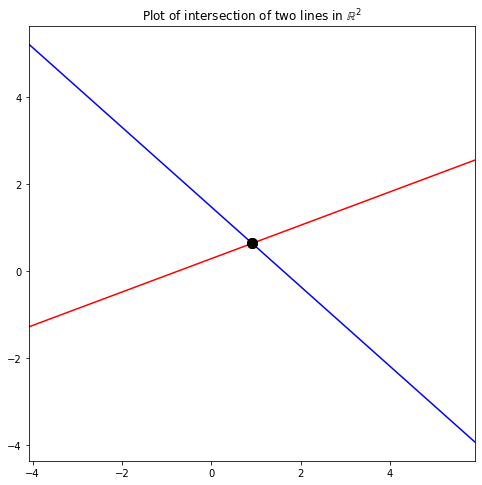

In [ ]:
def min_distance_lines(a1, u1, a2, u2):

    # BEGIN SOLUTION

    s = cp.Variable()
    t = cp.Variable()

    objective = cp.Minimize(cp.norm(a1 + u1 * s - (a2 + u2 * t)))
    problem = cp.Problem(objective, [])
    problem.solve()

    x = a1 + u1 * s.value
    y = a2 + u2 * t.value

    # END SOLUTION

    return x, y


# If your result is correct, then we should see a single dot right on the intersection of two lines

a1, u1, a2, u2 = np.random.normal(size=(4, 2))
x, y = min_distance_lines(a1, u1, a2, u2)

fig = plt.figure(figsize=(8, 8))


def plot_line(a, u, length=100, c="k"):
    """Plot a line given by a+t*u"""
    plt.plot(
        [a[0] - length * u[0], a[0] + length * u[0]],
        [a[1] - length * u[1], a[1] + length * u[1]],
        c=c,
    )


plot_line(a1, u1, c="b")
plot_line(a2, u2, c="r")
plt.title(r"Plot of intersection of two lines in $\mathbb{R}^2$")
plt.plot([x[0], y[0]], [x[1], y[1]], "ok", markersize=10)
plt.xlim(-5 + x[0], 5 + x[0])  # Set plot limits to crop the two lines
plt.ylim(-5 + x[1], 5 + x[1])
# The plot is centered around x

In [ ]:
def exercise3a_test():
    np.random.seed(179)

    def is_on_line(x, a, u):
        d = x - a
        d = d * np.linalg.norm(u) / np.linalg.norm(d)
        d *= np.sign(d[0] / u[0])
        return np.linalg.norm(d - u) < 1e-8

    for n in range(2, 5):  # try for n = 2, 3, 4
        a1, u1, a2, u2 = np.random.normal(size=(4, n))
        x, y = min_distance_lines(a1, u1, a2, u2)

        assert is_on_line(x, a1, u1), "x is not on the line"
        assert is_on_line(y, a2, u2), "y is not on the line"
        assert (
            np.abs(np.dot(x - y, u1)) < 1e-4
        ), "x-y should be orthogonal to both lines"
        assert (
            np.abs(np.dot(x - y, u2)) < 1e-4
        ), "x-y should be orthogonal to both lines"


exercise3a_test()

### Exercise 3b)

> Take as first convex set a line:  
$$S_1 = \ell = \{a + tu\mid t\in \mathbb R\}, \qquad a,u\in \mathbb R^n.$$  

> Take as second convex set an ellipsoid:
$$
    S_2 = \mathcal E = \{x\in\mathbb R^n \mid \|x-c\|_P \leq 1 \},\qquad c\in \mathbb R^n, \qquad P \in S^n_+
$$  

> That is, the ellipsoid defined by an $n\times n$ symmetric positive definite matrix $P$, centered around the point $c\in\mathbb R^n$. Recall that $\|x\|_P = \sqrt{x^TPx}$.  

> Complete the code for the function `min_distance_line_ellipsoid(a,u,c,P)` which solves problem ($\star$) in the case both convex sets are lines. It should return the two minimizing points on respectively the line $\ell$ and the ellipsoid $\mathcal E$.  

___  

Tip: Use [cp.quad_form(x,P)](https://www.cvxpy.org/api_reference/cvxpy.atoms.other_atoms.html#quad-form) to compute $\|x\|_P$.

In [ ]:
def min_distance_line_ellipsoid(a, u, c, P):

    # BEGIN SOLUTION
    n = len(a)
    t = cp.Variable()
    y = cp.Variable(n)

    objective = cp.Minimize(cp.norm(a + t * u - y))
    constraints = [cp.quad_form(y - c, P) <= 1]
    problem = cp.Problem(objective, constraints)
    problem.solve()

    x = a + t.value * u
    return x, y.value

    # END SOLUTION


def random_positive_definite(n):
    """Random positive definite matrix with eigenvalues in [0.5, 1]"""
    eigs = np.random.uniform(low=0.5, high=1, size=n)
    Q, _ = np.linalg.qr(np.random.normal(size=(n, n)))  # random orthogonal matrix
    P = Q.T @ np.diag(eigs) @ Q
    return P


n = 2
a, u, c = np.random.normal(size=(3, n))
c *= 5
P = random_positive_definite(n)

x, y = min_distance_line_ellipsoid(a, u, c, P)

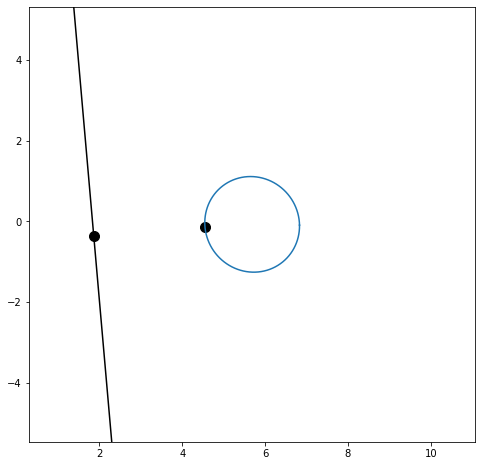

In [ ]:
# This is some code to plot the situation in 2D.
# Run this cell multiple times to get different configurations.

n = 2
a, u, c = np.random.normal(size=(3, n))
c *= 5
P = random_positive_definite(n)
x, y = min_distance_line_ellipsoid(a, u, c, P)


def plot_line(a, u, length=100, c="k"):
    """Plot a line given by a+t*u"""
    u = u / np.linalg.norm(u)
    plt.plot(
        [a[0] - length * u[0], a[0] + length * u[0]],
        [a[1] - length * u[1], a[1] + length * u[1]],
        c=c,
    )


plt.figure(figsize=(8, 8))

# Plot the lines, the points x,y and c
plot_line(a, u)
plt.plot([x[0], y[0]], [x[1], y[1]], "ok", markersize=10)

# Plot an ellipse by applying P^{-1/2} to a circle and adding +c
# this is the formula derived in homework week 1.3
P_sqrt = scipy.linalg.sqrtm(P)
P_sqrt_inv = np.linalg.inv(P_sqrt)
alpha = np.linspace(0, np.pi * 2, 100)
circle = np.stack([np.cos(alpha), np.sin(alpha)])
ellipse = P_sqrt_inv @ circle
ellipse = (c + ellipse.T).T
plt.plot(ellipse[0], ellipse[1])


plt_lims = max(5, np.linalg.norm(x - y) * 2)
plt.xlim(c[0] - plt_lims, c[0] + plt_lims)
plt.ylim(c[1] - plt_lims, c[1] + plt_lims);

In [ ]:
def exercise3b_test():
    np.random.seed(179)

    def is_on_line(x, a, u):
        d = x - a
        d = d * np.linalg.norm(u) / np.linalg.norm(d)
        d *= np.sign(d[0] / u[0])
        return np.linalg.norm(d - u) < 1e-8

    def is_in_ellipse(x, c, P):
        P_norm = np.sqrt((x - c).T @ P @ (x - c))
        return P_norm < 1 + 1e-4

    def is_on_ellipse_boundary(x, c, P):
        P_norm = np.sqrt((x - c).T @ P @ (x - c))
        return np.abs(P_norm - 1) < 1e-4

    for n in range(2, 5):  # try for n = 2, 3, 4
        for _ in range(10):  # repeat 10 times
            a, u, c = np.random.normal(size=(3, n))
            u = u / np.linalg.norm(u)
            P = random_positive_definite(n)
            x, y = min_distance_line_ellipsoid(a, u, c, P)

            assert is_on_line(x, a, u), "x is not on the line"
            assert is_in_ellipse(y, c, P), "y is not in the ellipse"

            if is_on_ellipse_boundary(y, c, P):
                assert (
                    np.abs(np.dot(x - y, u)) < 1e-4
                ), "x-y should be orthogonal to the line if y is on the boundary"
            else:
                assert (
                    np.linalg.norm(x - y) < 1e-4
                ), "if y is not on the boundary, then x=y"


exercise3b_test()

## Exercise 4


A _financial index_ is a weighted sum of stocks used to represent the overall performance of an entire market or sector. It is close to impossible to invest in stocks in such that you _consistently_ gain money at a higher rate than an index. Therefore for long-term investing it can be a good idea to try to match (_track_) an index. (_Disclaimer: This is not investment advice_)

An index can consist of many different stocks, and the composition can change over time. Hence if we want to track an index, it's more efficient to invest in a smaller number of stocks. In this exercise we will try to track the EURONEXT 100 index using two different sets of stocks. One list consists of several large American and European companies. The other consists of stocks trending on [/r/wallstreetbets](https://www.reddit.com/r/wallstreetbets/) (this subreddit made headlines in January for causing the [GameStop short squeeze](https://en.wikipedia.org/wiki/GameStop_short_squeeze)).

First of all we will download and process timeseries of stock data. We will use the Python package `yfinance` to download financial data from [Yahoo Finance](https://finance.yahoo.com/). We download two datasets, one with 'normal' stocks and one with 'meme' stocks. We will get data from between 2018-01 and 2021-03.

In [ ]:
index_ticker = "^N100"
normal_tickers = {
    "AIR.PA": "Airbus",
    "NSRGY": "Nestle",
    "GOOG": "Alphabet",
    "MSFT": "Microsoft",
    "CS": "Credit Suisse",
    "ING": "ING",
    "RDSB.AS": "Shell",
}
meme_tickers = {
    "GME": "Gamestop",
    "TSLA": "Tesla",
    "AMC": "AMC Entertainment",
    "EXPR": "Express",
    "KOSS": "Koss",
    "NOK": "Nokia",
}

start_date = "2018-01-02"
end_date = "2021-2-21"
date_range = pd.date_range(start_date, end_date)

# Download the data for the EURONEXT 100 index
data_index = yf.download(index_ticker, start=start_date, end=end_date)
data_index = data_index.reindex(date_range, fill_value=np.nan)

# Download the data for each of the normal tickers
data_normal = yf.download(
    " ".join(normal_tickers),
    start=start_date,
    end=end_date,
    interval="1d",
    group_by="ticker",
)

data_normal = data_normal.reindex(date_range, fill_value=np.nan)
# Download the data for each of the meme tickers
data_meme = yf.download(
    " ".join(meme_tickers),
    start=start_date,
    end=end_date,
    interval="1d",
    group_by="ticker",
)
data_meme = data_meme.reindex(date_range, fill_value=np.nan)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  6 of 6 completed


The two datasets are _Pandas dataframes_. Like numpy arrays, these are very frequently used objects to work with data in Python. Unlike a numpy array, a dataframe can store different types of data in the same object. For example, one column may consist of strings, another of dates and yet another of floating point numbers. Furthermore, Pandas can be used to perform advanced kinds of data manipulation very easily.

For each _key_ in the dictionary `normal_tickers` or `meme_tickers`, there is one DataFrame stored in `data_normal` (resp. `data_meme`). For example below we see `data_meme["GME"]`, which is the data corresponding to the GameStop stock.

In [ ]:
data_meme["GME"]

,Open,High,Low,Close,Adj Close,Volume
2018-01-02,17.959999,18.290001,17.780001,18.260000,15.953856,2832700.0
2018-01-03,18.290001,18.370001,17.920000,18.200001,15.901433,3789200.0
2018-01-04,18.200001,18.379999,17.959999,18.320000,16.006279,2781300.0
2018-01-05,18.379999,18.730000,18.219999,18.680000,16.320812,3019000.0
2018-01-06,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-02-17,49.770000,51.189999,44.560001,45.939999,45.939999,9186800.0
2021-02-18,48.490002,48.869999,40.650002,40.689999,40.689999,23990600.0
2021-02-19,41.279999,43.889999,38.500000,40.590000,40.590000,14828200.0
2021-02-20,NaN,NaN,NaN,NaN,NaN,NaN


If we want to access a column of `data_normal["GME"]` we can do that like this:

In [ ]:
data_meme["GME"]["Open"]

2018-01-02    17.959999
2018-01-03    18.290001
2018-01-04    18.200001
2018-01-05    18.379999
2018-01-06          NaN
                ...    
2021-02-17    49.770000
2021-02-18    48.490002
2021-02-19    41.279999
2021-02-20          NaN
2021-02-21          NaN
Freq: D, Name: Open, Length: 1147, dtype: float64

The result is a _pandas Series_. Like a pandas dataframe, it also stores an Index column, in this case a date. They are essentially one-dimensional dataframes. 

### Exercise 4a)

To properly compare different stocks we will need the time series to be normalized such that each starts with $1.0$ at the starting date. Furthermore we need to choose a column to work with. In this case we will work with the column which gives the price of the stock at _closing time_ of the stock exchange. Finally, the data may contain some missing values, which we want to replace. Some values may be missing because the stock exchange is not open on holidays.

___    
> Complete the code for the function `prepare_timeseries(ticker_data)` which takes as input a pandas dataframe associated to a ticker. It should take the column describing the price at closing of the stock exchange, normalized such that the first entry is 1.0.
>  
> Fill in the missing (NaN) values using [forward filling](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html), which replaces a missing value with the previous value in the column.
>  
> The final result should be a pandas Series with the same index as the Dataframe we started with.  

___  

In [ ]:
def prepare_timeseries(ticker_data):

    # BEGIN SOLUTION

    time_series = ticker_data["Close"]
    time_series = time_series.fillna(method="ffill")
    return time_series / time_series[0]

    # END SOLUTION


# Apply `prepare_timeseries` to all of the dataframes in data_normal
# The columns of the resulting dataframe are the names of the stocks
stocks_normal = pd.DataFrame(
    {
        name: prepare_timeseries(data_normal[tick])
        for tick, name in normal_tickers.items()
    }
)

# Apply `prepare_timeseries` to all of the dataframes in data_meme
# The columns of the resulting dataframe are the names of the stocks
stocks_meme = pd.DataFrame(
    {name: prepare_timeseries(data_meme[tick]) for tick, name in meme_tickers.items()}
)

index = prepare_timeseries(data_index)

In [ ]:
def exercise4a_tests():
    for data, mean_correct in zip(
        [stocks_normal, stocks_meme, index], [1.0581217250, 1.1118380976, 1.0030688361]
    ):
        assert (
            np.sum(data.isna().to_numpy()) == 0
        ), "The result still contains missing values"

        assert (
            np.linalg.norm(data.to_numpy()[0] - 1) < 1e-8
        ), "The result isn't correctly normalized"
        mean = np.mean(data.to_numpy())
        assert (
            np.abs(mean - mean_correct) < 1e-8
        ), f"""The mean of the result is wrong. We got {mean:.10f} instead of expected {mean_correct:.10f}.
        Check you filled the missing values in the right way, and that you used the right column"""


exercise4a_tests()

### Exercise 4b)

Now we will try to use these two different sets of stocks to match the EURONEXT 100 index. Let $y\in \mathbb R^N$ denote the tracker timeseries, and let $X\in\mathbb R^{N\times m}$ denote the timeseries of all other stocks. Then we try to find a vector $c\in \mathbb R^m$ giving the convex combination of stocks to choose to best match $y$. This is a quadratic program, called the _index tracking problem_:

$$
    \begin{array}{ll}
    \text{Minimize} & \|Xc-y\|_2\\
    \text{Subject to} & \sum_{i=1}^mc = 1,\quad c\geq 0
    \end{array}
$$

___  
> Complete the code for the functioon `fit_tracker(stocks_data)`, which takes as input either the dataset `stocks_normal` or `stocks_meme`, and as output gives the vector $c$ solving the index tracking problem.

___  

Hints:
- You can turn a DataFrame to a numpy array using `.to_numpy()`. CVXPY in principle only supports numpy arrays 

In [ ]:
def fit_tracker(stocks_data):

    # BEGIN SOLUTION

    X = stocks_data.to_numpy()
    y = index.to_numpy()

    m = X.shape[-1]

    c = cp.Variable(m)
    objective = cp.Minimize(cp.norm(X @ c - y))
    constraints = [c >= 0, c.T @ np.ones(m) == 1]
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return c.value

    # END SOLUTION


normal_tracker = pd.Series(fit_tracker(stocks_normal), index=stocks_normal.columns)
meme_tracker = pd.Series(fit_tracker(stocks_meme), index=stocks_meme.columns)

Optimal distribution of 'normal' stocks
--------------------


Airbus           0.071718
Nestle           0.142132
Alphabet         0.083037
Microsoft        0.122017
Credit Suisse    0.231720
ING              0.039679
Shell            0.309695
dtype: float64


Optimal distribution of 'meme' stocks
--------------------


Gamestop             4.365797e-11
Tesla                3.428337e-02
AMC Entertainment    2.754243e-10
Express              1.405493e-01
Koss                 3.363947e-11
Nokia                8.251674e-01
dtype: float64

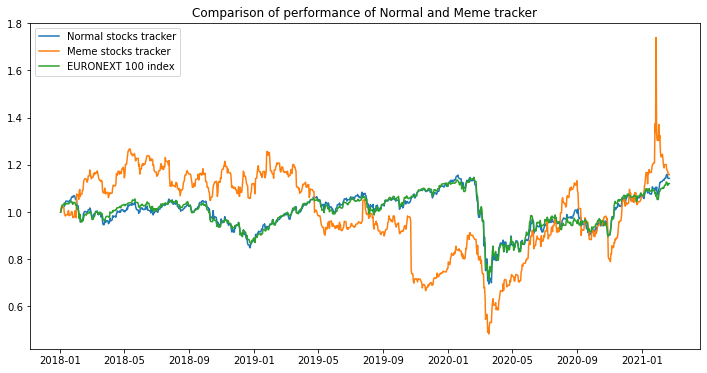

In [ ]:
print("Optimal distribution of 'normal' stocks\n" + "-" * 20)
display(normal_tracker)
print("\nOptimal distribution of 'meme' stocks\n" + "-" * 20)
display(meme_tracker)

plt.figure(figsize=(12,6))
plt.plot(stocks_normal @ fit_tracker(stocks_normal), label="Normal stocks tracker")
plt.plot(stocks_meme @ fit_tracker(stocks_meme), label="Meme stocks tracker")
plt.plot(index, label="EURONEXT 100 index")
plt.title("Comparison of performance of Normal and Meme tracker")
plt.legend();

In [ ]:
def exercise4b_tests():
    for stocks_data, mean_true, error_true in zip(
        [stocks_normal, stocks_meme],
        [0.1428571428571, 0.166666666],
        [0.0002199384890, 0.02959994779],
    ):
        tracker = fit_tracker(stocks_data)
        assert np.abs(1 - tracker.sum()) < 1e-4, "The output should sum to one"
        assert np.all(meme_tracker >= 0), "The output should be positive"
        mean = tracker.mean()
        assert (
            np.abs(mean - mean_true) < 1e-4
        ), f"""The mean value is {mean:.6f}, but should be {mean_true:.6f}"""
        error = np.mean((stocks_data @ tracker - index) ** 2)
        assert (
            np.abs(error - error_true) < 1e-4
        ), f"""The mean squared error is {error:.4e}, but it should be {error_true:.4e}"""


exercise4b_tests()